### Import Library

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os

### Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/My Drive/Dataset'

os.listdir(dataset_path)

['README.roboflow.txt', 'README.dataset.txt', 'train', 'test', 'valid']

### Dataset Directory

In [ ]:
# Path to the dataset directories
train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'valid')
test_dir = os.path.join(dataset_path, 'test')

### Data Augmentation

In [ ]:
# ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 635 images belonging to 18 classes.
Found 179 images belonging to 18 classes.
Found 89 images belonging to 18 classes.


### Model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(18, activation='softmax')  # 18 kelas makanan
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
20/20 [==============================] - 235s 12s/step - loss: 1.8378 - accuracy: 0.4409 - val_loss: 1.2032 - val_accuracy: 0.6369
Epoch 2/10
20/20 [==============================] - 53s 3s/step - loss: 0.6254 - accuracy: 0.8157 - val_loss: 0.6354 - val_accuracy: 0.7989
Epoch 3/10
20/20 [==============================] - 51s 3s/step - loss: 0.3617 - accuracy: 0.8850 - val_loss: 0.5809 - val_accuracy: 0.8547
Epoch 4/10
20/20 [==============================] - 50s 2s/step - loss: 0.2524 - accuracy: 0.9181 - val_loss: 0.5618 - val_accuracy: 0.8380
Epoch 5/10
20/20 [==============================] - 47s 2s/step - loss: 0.2373 - accuracy: 0.9118 - val_loss: 0.5522 - val_accuracy: 0.8324
Epoch 6/10
20/20 [==============================] - 48s 2s/step - loss: 0.1710 - accuracy: 0.9543 - val_loss: 0.5971 - val_accuracy: 0.8101
Epoch 7/10
20/20 [==============================] - 48s 2s/step - loss: 0.1255 - accuracy: 0.9575 - val_loss: 0.5396 - val_accuracy: 0.8715
Epoch 8/10
20/20 [

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}')

3/3 [==============================] - 23s 10s/step - loss: 0.2118 - accuracy: 0.9438
Test accuracy: 0.9438202381134033


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

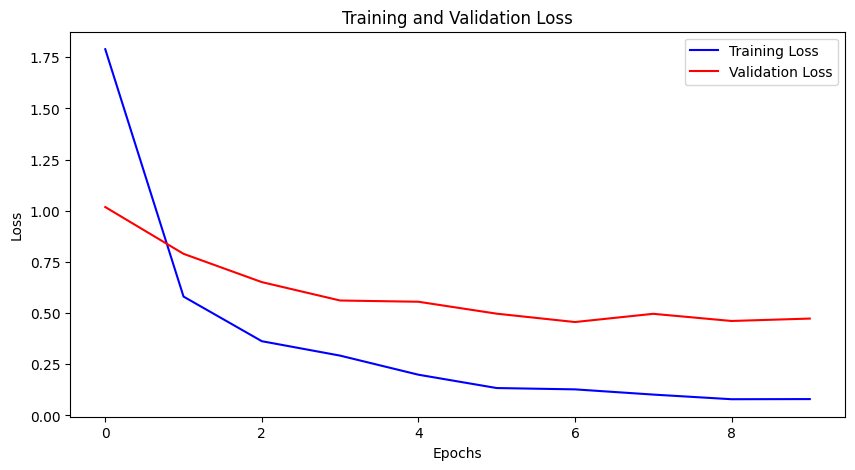

In [ ]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

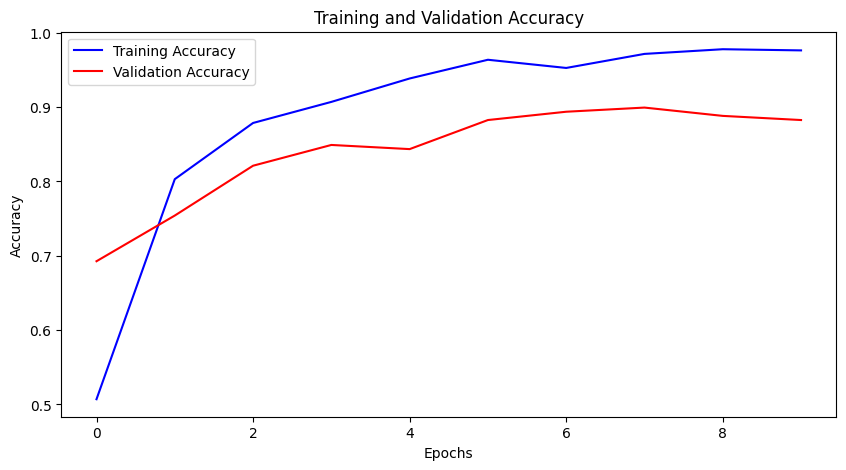

In [ ]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Model Conversion

In [ ]:
model.save('food_classification_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('food_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np

# Fungsi untuk memuat model dari file .h5 dan menambahkan fungsi estimasi kalori
def load_and_convert_model(model_path, calorie_reference):
    # Load model Keras
    model = tf.keras.models.load_model(model_path)

    # Fungsi untuk estimasi kalori berdasarkan prediksi kelas makanan
    def estimate_calories(food_class_index, weight):
        class_names = [
            "Ayam Betutu", "Beberuk Terong", "Coto Makassar", "Gudeg",
            "Kerak Telor", "Mie Aceh", "Nasi Kuning", "Nasi Pecel",
            "Papeda", "Pempek", "Peuyeum", "Rawon", "Rendang",
            "Sate Madura", "Serabi", "Soto Banjar", "Soto Lamongan", "Tahu Sumedang"
        ]

        predicted_class = class_names[food_class_index]
        if predicted_class in calorie_reference:
            calories_per_100g = calorie_reference[predicted_class]
            calories = (weight * calories_per_100g) / 100
            return calories
        else:
            return None

    # Simpan model Keras ke file .h5
    model.save('food_classification_model.h5')

    # Konversi model Keras menjadi model TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Definisi fungsi tambahan untuk estimasi kalori sebagai bagian dari model TFLite
    def post_processing(input_data):
        food_class_index = np.argmax(input_data)
        weight = input_details['weight']
        calories = estimate_calories(food_class_index, weight)
        return np.array([calories])

    converter.experimental_post_training_quantization = True
    converter.post_training_quantize = True
    tflite_model = converter.convert()

    # Simpan model TFLite ke file .tflite
    with open('food_classification_model.tflite', 'wb') as f:
        f.write(tflite_model)

    return 'food_classification_model.tflite'

# Contoh penggunaan
calorie_reference = {
    "Ayam Betutu": 150,
    "Beberuk Terong": 80,
    "Coto Makassar": 300,
    "Gudeg": 200,
    "Kerak Telor": 300,
    "Mie Aceh": 350,
    "Nasi Kuning": 150,
    "Nasi Pecel": 200,
    "Papeda": 100,
    "Pempek": 150,
    "Peuyeum": 200,
    "Rawon": 250,
    "Rendang": 300,
    "Sate Madura": 200,
    "Serabi": 100,
    "Soto Banjar": 200,
    "Soto Lamongan": 250,
    "Tahu Sumedang": 150
}

model_path = "food_classification_model.h5"  # Ganti dengan path model Keras Anda
tflite_model_path = load_and_convert_model(model_path, calorie_reference)
print(f"Model TFLite berhasil disimpan di: {tflite_model_path}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model TFLite berhasil disimpan di: food_classification_model.tflite


In [ ]:
from google.colab import files
files.download('food_classification_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf

# Fungsi untuk memuat model TFLite
def load_tflite_model(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    return interpreter, input_details, output_details

# Memuat model TFLite yang sudah dilatih
model_path = "food_classification_model.tflite"  # Ganti dengan path model TFLite Anda
interpreter, input_details, output_details = load_tflite_model(model_path)

In [ ]:
from google.colab import files
from PIL import Image
import numpy as np
import io

# Fungsi untuk memuat gambar dari sistem lokal ke Colab
def load_image_from_local():
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    img_data = uploaded[file_name]
    image = Image.open(io.BytesIO(img_data))
    return image, file_name

# Fungsi untuk memproses gambar
def preprocess_image(image):
    # Lakukan praproses gambar sesuai dengan yang dibutuhkan oleh model TFLite
    # Contoh: resize gambar, normalisasi, dll.
    resized_image = image.resize((224, 224))  # Ubah sesuai dengan kebutuhan model TFLite Anda
    return np.asarray(resized_image)

# Fungsi untuk memprediksi kelas makanan dari gambar menggunakan model TFLite
def predict_food_class(image, interpreter, input_details, output_details):
    input_shape = input_details[0]['shape']
    input_data = preprocess_image(image)
    input_data = np.expand_dims(input_data, axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class_index = np.argmax(output_data)
    return predicted_class_index

# Fungsi untuk menghitung estimasi kalori berdasarkan prediksi kelas makanan dan berat makanan
def estimate_calories(food_class_index, weight):
    # Daftar kelas makanan yang sesuai dengan output model TFLite
    class_names = [
        "Ayam Betutu", "Beberuk Terong", "Coto Makassar", "Gudeg",
        "Kerak Telor", "Mie Aceh", "Nasi Kuning", "Nasi Pecel",
        "Papeda", "Pempek", "Peuyeum", "Rawon", "Rendang",
        "Sate Madura", "Serabi", "Soto Banjar", "Soto Lamongan", "Tahu Sumedang"
    ]

    calorie_reference = {
        "Ayam Betutu": 150,
        "Beberuk Terong": 80,
        "Coto Makassar": 300,
        "Gudeg": 200,
        "Kerak Telor": 300,
        "Mie Aceh": 350,
        "Nasi Kuning": 150,
        "Nasi Pecel": 200,
        "Papeda": 100,
        "Pempek": 150,
        "Peuyeum": 200,
        "Rawon": 250,
        "Rendang": 300,
        "Sate Madura": 200,
        "Serabi": 100,
        "Soto Banjar": 200,
        "Soto Lamongan": 250,
        "Tahu Sumedang": 150
    }

    predicted_class = class_names[food_class_index]
    if predicted_class in calorie_reference:
        calories_per_100g = calorie_reference[predicted_class]
        calories = (weight * calories_per_100g) / 100
        return predicted_class, calories
    else:
        return None, None

In [ ]:
# Contoh penggunaan
print("Silakan unggah gambar makanan:")
image, file_name = load_image_from_local()

# Meminta input untuk berat makanan
weight = float(input("Masukkan berat makanan dalam gram: "))

# Panggil fungsi untuk memprediksi kelas makanan
food_class_index = predict_food_class(image, interpreter, input_details, output_details)

# Hitung estimasi kalori berdasarkan prediksi kelas makanan dan berat makanan
food_class_predicted, estimated_calories = estimate_calories(food_class_index, weight)

# Tampilkan hasilnya
if food_class_predicted is not None and estimated_calories is not None:
    print(f"Jenis makanan: {food_class_predicted}")
    print(f"Estimasi kalori untuk {food_class_predicted} dengan berat {weight} gram adalah: {estimated_calories} kalori")
else:
    print("Makanan tidak ditemukan dalam referensi kalori atau terjadi kesalahan dalam prediksi.")

Silakan unggah gambar makanan:


Saving papeda.jpg to papeda.jpg
Masukkan berat makanan dalam gram: 150
Jenis makanan: Serabi
Estimasi kalori untuk Serabi dengan berat 150.0 gram adalah: 150.0 kalori
